# Import Datasets(dog & human)

In [1]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
from glob import glob

def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']) , 133)
    return dog_files , dog_targets

train_files , train_targets = load_dataset('dogImages/train')
valid_files , valid_targets = load_dataset('dogImages/valid')
test_files , test_targets = load_dataset('dogImages/test')

dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

print('there are %d total dog categories'% len(dog_names))
print('there are %s total dog images\n' %len(np.hstack([train_files , valid_files , test_files])))
print('there are %d training dog images' %len(train_files))
print('there are %d validation dog images' %len(valid_files))
print('there are %d testing dog images' %len(test_files))

Using TensorFlow backend.


there are 133 total dog categories
there are 8351 total dog images

there are 6680 training dog images
there are 835 validation dog images
there are 836 testing dog images


In [3]:
import random
random.seed(8675309)

human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

print('there are %d total human images' %len(human_files))

there are 13233 total human images


# Detect humans

number of faces detected: 2


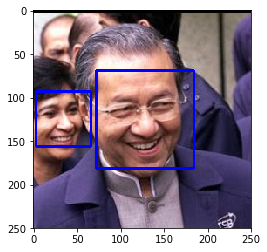

In [4]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

img = cv2.imread(human_files[14])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray)

print('number of faces detected:', len(faces))

for (x , y , w , h) in faces:
    cv2.rectangle(img , (x , y) , (x + w , y + h) , (255 , 0 , 0) , 2)
    
cv_rgb = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)

plt.imshow(cv_rgb)
plt.show()

### Human Face Dectector :--

In [5]:
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [6]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
y = 0
z = 0

for i in range(len(human_files_short)):
    x = face_detector(human_files_short[i])
    if (x!=0):
        y = y+1

for i in range(len(dog_files_short)):
    x = face_detector(dog_files_short[i])
    if (x!=0):
        z = z+1
print('%d percentage of human images were with a detected human face' % (y))
print('%d percentage of dog images were with a detected human face' % (z))

99 percentage of human images were with a detected human face
12 percentage of dog images were with a detected human face


# Detect dogs

In [7]:
from keras.applications.resnet50 import ResNet50

ResNet50_model = ResNet50(weights = 'imagenet')

Instructions for updating:
Colocations handled automatically by placer.


### Preprocess the data :--

In [8]:
from keras.preprocessing import image
from tqdm import tqdm

def path_to_tensor(img_path):
    img = image.load_img(img_path , target_size = (224 , 224))
    x = image.img_to_array(img)
    return np.expand_dims(x , axis = 0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making predictions :--

In [9]:
from keras.applications.resnet50 import preprocess_input , decode_predictions

def ResNet50_predict_labels(img_path):
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Dog Detector

In [10]:
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return((prediction <= 268) & (prediction >= 151))

In [11]:
y = 0
z = 0

for i in range(len(human_files_short)):
    x = dog_detector(human_files_short[i])
    if (x == True):
        y = y+1

for i in range(len(dog_files_short)):
    x = dog_detector(dog_files_short[i])
    if (x == True):
        z = z+1
print('%d percentage of human images were with a detected human face' % (y))
print('%d percentage of dog images were with a detected human face' % (z))

1 percentage of human images were with a detected human face
100 percentage of dog images were with a detected human face


In [12]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|███████████████████████████████████████████████████████████████████████████████| 836/836 [00:06<00:00, 125.01it/s]


# Model Architecture

In [13]:
from keras.layers import Conv2D , MaxPooling2D , GlobalAveragePooling2D
from keras.layers import Dropout , Flatten , Dense
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(filters = 16 , kernel_size = 2 , padding = 'same' , activation = 'relu' , input_shape = (224 , 224 , 3)))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 32 , kernel_size = 2 , padding = 'same' , activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 64 , kernel_size = 2 , padding = 'same' , activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(512 , activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(133 , activation = 'softmax'))
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 64)        0         
___________________________

# Compile the model

In [14]:
model.compile(optimizer = 'rmsprop' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])


# Train the model

In [15]:
from keras.callbacks import ModelCheckpoint  

epochs = 25

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5' , verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets , validation_data=(valid_tensors, valid_targets) , epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 6680 samples, validate on 835 samples
Epoch 1/25


4040/6680 [=================>............] - ETA: 1:54:47 - loss: 4.8852 - acc: 0.0000e+ - ETA: 59:26 - loss: 9.7164 - acc: 0.0000e+00 - ETA: 40:33 - loss: 9.1586 - acc: 0.0000e+ - ETA: 31:13 - loss: 8.3144 - acc: 0.0000e+ - ETA: 25:39 - loss: 7.6572 - acc: 0.0000e+ - ETA: 21:55 - loss: 7.2467 - acc: 0.0000e+ - ETA: 19:09 - loss: 6.9291 - acc: 0.0000e+ - ETA: 17:10 - loss: 6.6834 - acc: 0.0000e+ - ETA: 15:34 - loss: 6.5038 - acc: 0.0000e+ - ETA: 14:18 - loss: 6.3475 - acc: 0.0000e+ - ETA: 13:17 - loss: 6.2145 - acc: 0.0000e+ - ETA: 12:23 - loss: 6.1066 - acc: 0.0000e+ - ETA: 11:41 - loss: 6.0195 - acc: 0.0000e+ - ETA: 11:01 - loss: 5.9425 - acc: 0.0000e+ - ETA: 10:29 - loss: 5.8710 - acc: 0.0000e+ - ETA: 9:59 - loss: 5.8086 - acc: 0.0000e+00 - ETA: 9:32 - loss: 5.7538 - acc: 0.0000e+0 - ETA: 9:10 - loss: 5.7034 - acc: 0.0000e+0 - ETA: 8:50 - loss: 5.6605 - acc: 0.0000e+0 - ETA: 8:30 - loss: 5.6222 - acc: 0.0000e+0 - ETA: 8:14 - loss: 5.5880 - acc: 0.0000e+0 - ETA: 7:59 - loss: 5.5578 -

6680/6680 [==============================] - ETA: 1:28 - loss: 4.9558 - acc: 0.012 - ETA: 1:27 - loss: 4.9555 - acc: 0.012 - ETA: 1:27 - loss: 4.9547 - acc: 0.012 - ETA: 1:26 - loss: 4.9542 - acc: 0.012 - ETA: 1:25 - loss: 4.9534 - acc: 0.012 - ETA: 1:24 - loss: 4.9524 - acc: 0.012 - ETA: 1:24 - loss: 4.9514 - acc: 0.012 - ETA: 1:23 - loss: 4.9506 - acc: 0.011 - ETA: 1:22 - loss: 4.9508 - acc: 0.012 - ETA: 1:21 - loss: 4.9507 - acc: 0.012 - ETA: 1:21 - loss: 4.9500 - acc: 0.012 - ETA: 1:20 - loss: 4.9494 - acc: 0.012 - ETA: 1:19 - loss: 4.9482 - acc: 0.012 - ETA: 1:18 - loss: 4.9470 - acc: 0.012 - ETA: 1:18 - loss: 4.9470 - acc: 0.012 - ETA: 1:17 - loss: 4.9460 - acc: 0.012 - ETA: 1:16 - loss: 4.9453 - acc: 0.012 - ETA: 1:16 - loss: 4.9451 - acc: 0.012 - ETA: 1:15 - loss: 4.9445 - acc: 0.012 - ETA: 1:14 - loss: 4.9436 - acc: 0.012 - ETA: 1:13 - loss: 4.9433 - acc: 0.012 - ETA: 1:13 - loss: 4.9435 - acc: 0.012 - ETA: 1:12 - loss: 4.9433 - acc: 0.012 - ETA: 1:11 - loss: 4.9427 - acc: 0.0

4080/6680 [=================>............] - ETA: 2:53 - loss: 4.5717 - acc: 0.0000e+0 - ETA: 3:00 - loss: 4.4517 - acc: 0.0500    - ETA: 2:58 - loss: 4.6393 - acc: 0.033 - ETA: 2:58 - loss: 4.6362 - acc: 0.025 - ETA: 2:56 - loss: 4.6314 - acc: 0.020 - ETA: 2:58 - loss: 4.5735 - acc: 0.025 - ETA: 2:57 - loss: 4.5776 - acc: 0.021 - ETA: 2:57 - loss: 4.5873 - acc: 0.025 - ETA: 2:55 - loss: 4.5956 - acc: 0.027 - ETA: 2:56 - loss: 4.5892 - acc: 0.035 - ETA: 2:56 - loss: 4.5938 - acc: 0.036 - ETA: 2:57 - loss: 4.5893 - acc: 0.041 - ETA: 2:57 - loss: 4.6084 - acc: 0.038 - ETA: 2:58 - loss: 4.6098 - acc: 0.035 - ETA: 2:59 - loss: 4.6115 - acc: 0.033 - ETA: 2:58 - loss: 4.6145 - acc: 0.031 - ETA: 2:57 - loss: 4.6153 - acc: 0.029 - ETA: 2:56 - loss: 4.6145 - acc: 0.027 - ETA: 2:56 - loss: 4.6159 - acc: 0.028 - ETA: 2:55 - loss: 4.6128 - acc: 0.027 - ETA: 2:54 - loss: 4.6196 - acc: 0.028 - ETA: 2:54 - loss: 4.6125 - acc: 0.029 - ETA: 2:54 - loss: 4.6029 - acc: 0.030 - ETA: 2:53 - loss: 4.5945 - 

6680/6680 [==============================] - ETA: 1:12 - loss: 4.5143 - acc: 0.044 - ETA: 1:11 - loss: 4.5135 - acc: 0.045 - ETA: 1:10 - loss: 4.5145 - acc: 0.045 - ETA: 1:10 - loss: 4.5150 - acc: 0.045 - ETA: 1:09 - loss: 4.5159 - acc: 0.045 - ETA: 1:09 - loss: 4.5163 - acc: 0.045 - ETA: 1:08 - loss: 4.5145 - acc: 0.046 - ETA: 1:08 - loss: 4.5134 - acc: 0.045 - ETA: 1:07 - loss: 4.5128 - acc: 0.045 - ETA: 1:07 - loss: 4.5132 - acc: 0.045 - ETA: 1:06 - loss: 4.5143 - acc: 0.045 - ETA: 1:05 - loss: 4.5128 - acc: 0.045 - ETA: 1:05 - loss: 4.5126 - acc: 0.045 - ETA: 1:04 - loss: 4.5126 - acc: 0.045 - ETA: 1:04 - loss: 4.5121 - acc: 0.045 - ETA: 1:03 - loss: 4.5129 - acc: 0.045 - ETA: 1:03 - loss: 4.5128 - acc: 0.045 - ETA: 1:02 - loss: 4.5122 - acc: 0.045 - ETA: 1:02 - loss: 4.5116 - acc: 0.044 - ETA: 1:01 - loss: 4.5111 - acc: 0.045 - ETA: 1:00 - loss: 4.5097 - acc: 0.045 - ETA: 1:00 - loss: 4.5097 - acc: 0.045 - ETA: 59s - loss: 4.5100 - acc: 0.045 - ETA: 59s - loss: 4.5108 - acc: 0.04 

4080/6680 [=================>............] - ETA: 2:48 - loss: 4.0909 - acc: 0.150 - ETA: 2:54 - loss: 3.9759 - acc: 0.175 - ETA: 2:53 - loss: 4.0424 - acc: 0.133 - ETA: 2:55 - loss: 4.0696 - acc: 0.137 - ETA: 2:56 - loss: 3.9930 - acc: 0.140 - ETA: 2:55 - loss: 3.9788 - acc: 0.141 - ETA: 2:57 - loss: 4.0182 - acc: 0.135 - ETA: 2:57 - loss: 4.0584 - acc: 0.125 - ETA: 2:57 - loss: 4.0563 - acc: 0.122 - ETA: 2:56 - loss: 4.0528 - acc: 0.120 - ETA: 2:55 - loss: 4.0466 - acc: 0.122 - ETA: 2:54 - loss: 4.0337 - acc: 0.133 - ETA: 2:54 - loss: 4.0681 - acc: 0.123 - ETA: 2:54 - loss: 4.0496 - acc: 0.128 - ETA: 2:53 - loss: 4.0398 - acc: 0.123 - ETA: 2:53 - loss: 4.0157 - acc: 0.125 - ETA: 2:52 - loss: 4.0184 - acc: 0.120 - ETA: 2:52 - loss: 4.0255 - acc: 0.119 - ETA: 2:53 - loss: 4.0263 - acc: 0.121 - ETA: 2:53 - loss: 4.0323 - acc: 0.117 - ETA: 2:52 - loss: 4.0463 - acc: 0.111 - ETA: 2:52 - loss: 4.0515 - acc: 0.109 - ETA: 2:51 - loss: 4.0657 - acc: 0.106 - ETA: 2:51 - loss: 4.0694 - acc: 0.1

6680/6680 [==============================] - ETA: 1:12 - loss: 4.0065 - acc: 0.108 - ETA: 1:11 - loss: 4.0044 - acc: 0.109 - ETA: 1:11 - loss: 4.0035 - acc: 0.109 - ETA: 1:10 - loss: 4.0037 - acc: 0.109 - ETA: 1:10 - loss: 3.9996 - acc: 0.110 - ETA: 1:09 - loss: 3.9974 - acc: 0.111 - ETA: 1:09 - loss: 3.9961 - acc: 0.110 - ETA: 1:08 - loss: 3.9941 - acc: 0.111 - ETA: 1:08 - loss: 3.9959 - acc: 0.111 - ETA: 1:07 - loss: 3.9956 - acc: 0.111 - ETA: 1:06 - loss: 3.9957 - acc: 0.110 - ETA: 1:06 - loss: 3.9972 - acc: 0.110 - ETA: 1:05 - loss: 3.9956 - acc: 0.111 - ETA: 1:05 - loss: 3.9976 - acc: 0.110 - ETA: 1:04 - loss: 3.9975 - acc: 0.110 - ETA: 1:04 - loss: 3.9953 - acc: 0.111 - ETA: 1:03 - loss: 3.9947 - acc: 0.111 - ETA: 1:02 - loss: 3.9963 - acc: 0.111 - ETA: 1:02 - loss: 3.9968 - acc: 0.110 - ETA: 1:01 - loss: 3.9963 - acc: 0.110 - ETA: 1:01 - loss: 3.9955 - acc: 0.110 - ETA: 1:00 - loss: 3.9931 - acc: 0.111 - ETA: 1:00 - loss: 3.9932 - acc: 0.111 - ETA: 59s - loss: 3.9915 - acc: 0.11

4080/6680 [=================>............] - ETA: 3:09 - loss: 3.5680 - acc: 0.150 - ETA: 3:11 - loss: 3.1990 - acc: 0.275 - ETA: 3:09 - loss: 3.1225 - acc: 0.266 - ETA: 3:10 - loss: 3.2039 - acc: 0.262 - ETA: 3:11 - loss: 3.1927 - acc: 0.270 - ETA: 3:13 - loss: 3.2110 - acc: 0.258 - ETA: 3:11 - loss: 3.2227 - acc: 0.257 - ETA: 3:10 - loss: 3.2308 - acc: 0.256 - ETA: 3:10 - loss: 3.1655 - acc: 0.261 - ETA: 3:10 - loss: 3.1692 - acc: 0.250 - ETA: 3:09 - loss: 3.2109 - acc: 0.231 - ETA: 3:08 - loss: 3.2327 - acc: 0.220 - ETA: 3:06 - loss: 3.2310 - acc: 0.219 - ETA: 3:06 - loss: 3.2609 - acc: 0.225 - ETA: 3:04 - loss: 3.2847 - acc: 0.226 - ETA: 3:04 - loss: 3.2509 - acc: 0.240 - ETA: 3:02 - loss: 3.2855 - acc: 0.235 - ETA: 3:02 - loss: 3.2747 - acc: 0.244 - ETA: 3:02 - loss: 3.2712 - acc: 0.242 - ETA: 3:01 - loss: 3.3004 - acc: 0.237 - ETA: 3:00 - loss: 3.3177 - acc: 0.231 - ETA: 3:00 - loss: 3.3138 - acc: 0.231 - ETA: 2:59 - loss: 3.2898 - acc: 0.234 - ETA: 2:58 - loss: 3.2742 - acc: 0.2

6680/6680 [==============================] - ETA: 1:12 - loss: 3.2259 - acc: 0.236 - ETA: 1:11 - loss: 3.2257 - acc: 0.236 - ETA: 1:11 - loss: 3.2242 - acc: 0.237 - ETA: 1:10 - loss: 3.2227 - acc: 0.237 - ETA: 1:10 - loss: 3.2220 - acc: 0.237 - ETA: 1:09 - loss: 3.2215 - acc: 0.237 - ETA: 1:09 - loss: 3.2213 - acc: 0.237 - ETA: 1:08 - loss: 3.2220 - acc: 0.237 - ETA: 1:07 - loss: 3.2181 - acc: 0.237 - ETA: 1:07 - loss: 3.2160 - acc: 0.237 - ETA: 1:06 - loss: 3.2130 - acc: 0.237 - ETA: 1:06 - loss: 3.2119 - acc: 0.238 - ETA: 1:05 - loss: 3.2138 - acc: 0.238 - ETA: 1:05 - loss: 3.2129 - acc: 0.238 - ETA: 1:04 - loss: 3.2107 - acc: 0.238 - ETA: 1:04 - loss: 3.2087 - acc: 0.238 - ETA: 1:03 - loss: 3.2070 - acc: 0.239 - ETA: 1:02 - loss: 3.2059 - acc: 0.239 - ETA: 1:02 - loss: 3.2079 - acc: 0.239 - ETA: 1:01 - loss: 3.2058 - acc: 0.240 - ETA: 1:01 - loss: 3.2065 - acc: 0.240 - ETA: 1:00 - loss: 3.2068 - acc: 0.240 - ETA: 1:00 - loss: 3.2086 - acc: 0.240 - ETA: 59s - loss: 3.2087 - acc: 0.24

4080/6680 [=================>............] - ETA: 3:18 - loss: 2.2735 - acc: 0.500 - ETA: 3:07 - loss: 2.2726 - acc: 0.500 - ETA: 3:09 - loss: 2.1699 - acc: 0.500 - ETA: 3:06 - loss: 2.2271 - acc: 0.500 - ETA: 3:05 - loss: 2.1245 - acc: 0.520 - ETA: 3:04 - loss: 2.1605 - acc: 0.508 - ETA: 3:03 - loss: 2.1549 - acc: 0.507 - ETA: 3:03 - loss: 2.1690 - acc: 0.500 - ETA: 3:05 - loss: 2.1393 - acc: 0.505 - ETA: 3:03 - loss: 2.1313 - acc: 0.495 - ETA: 3:02 - loss: 2.0871 - acc: 0.504 - ETA: 3:00 - loss: 2.0732 - acc: 0.491 - ETA: 2:59 - loss: 2.0782 - acc: 0.484 - ETA: 2:59 - loss: 2.1068 - acc: 0.467 - ETA: 2:59 - loss: 2.1638 - acc: 0.456 - ETA: 2:58 - loss: 2.1686 - acc: 0.462 - ETA: 2:58 - loss: 2.1785 - acc: 0.458 - ETA: 2:57 - loss: 2.2035 - acc: 0.455 - ETA: 2:57 - loss: 2.2231 - acc: 0.450 - ETA: 2:56 - loss: 2.2413 - acc: 0.445 - ETA: 2:55 - loss: 2.2308 - acc: 0.440 - ETA: 2:55 - loss: 2.2264 - acc: 0.440 - ETA: 2:54 - loss: 2.2103 - acc: 0.443 - ETA: 2:53 - loss: 2.1946 - acc: 0.4

6680/6680 [==============================] - ETA: 1:12 - loss: 2.1701 - acc: 0.467 - ETA: 1:11 - loss: 2.1684 - acc: 0.467 - ETA: 1:10 - loss: 2.1654 - acc: 0.468 - ETA: 1:10 - loss: 2.1681 - acc: 0.467 - ETA: 1:09 - loss: 2.1699 - acc: 0.467 - ETA: 1:09 - loss: 2.1689 - acc: 0.467 - ETA: 1:08 - loss: 2.1692 - acc: 0.467 - ETA: 1:08 - loss: 2.1686 - acc: 0.467 - ETA: 1:07 - loss: 2.1672 - acc: 0.467 - ETA: 1:07 - loss: 2.1684 - acc: 0.468 - ETA: 1:06 - loss: 2.1708 - acc: 0.467 - ETA: 1:05 - loss: 2.1720 - acc: 0.467 - ETA: 1:05 - loss: 2.1727 - acc: 0.467 - ETA: 1:04 - loss: 2.1732 - acc: 0.467 - ETA: 1:04 - loss: 2.1721 - acc: 0.467 - ETA: 1:03 - loss: 2.1736 - acc: 0.468 - ETA: 1:03 - loss: 2.1732 - acc: 0.467 - ETA: 1:02 - loss: 2.1732 - acc: 0.467 - ETA: 1:02 - loss: 2.1758 - acc: 0.467 - ETA: 1:01 - loss: 2.1749 - acc: 0.467 - ETA: 1:00 - loss: 2.1774 - acc: 0.466 - ETA: 1:00 - loss: 2.1765 - acc: 0.465 - ETA: 59s - loss: 2.1739 - acc: 0.466 - ETA: 59s - loss: 2.1736 - acc: 0.46 

4080/6680 [=================>............] - ETA: 3:19 - loss: 0.8339 - acc: 0.800 - ETA: 3:06 - loss: 1.0775 - acc: 0.750 - ETA: 3:03 - loss: 1.1588 - acc: 0.700 - ETA: 3:03 - loss: 1.2197 - acc: 0.700 - ETA: 3:02 - loss: 1.3649 - acc: 0.670 - ETA: 3:03 - loss: 1.4167 - acc: 0.666 - ETA: 3:01 - loss: 1.3457 - acc: 0.685 - ETA: 3:01 - loss: 1.3369 - acc: 0.681 - ETA: 3:00 - loss: 1.4056 - acc: 0.661 - ETA: 2:59 - loss: 1.4345 - acc: 0.645 - ETA: 2:59 - loss: 1.4648 - acc: 0.622 - ETA: 2:59 - loss: 1.4219 - acc: 0.641 - ETA: 2:59 - loss: 1.4320 - acc: 0.638 - ETA: 2:59 - loss: 1.4187 - acc: 0.642 - ETA: 2:58 - loss: 1.3817 - acc: 0.656 - ETA: 2:58 - loss: 1.3911 - acc: 0.653 - ETA: 2:57 - loss: 1.4175 - acc: 0.647 - ETA: 2:57 - loss: 1.4082 - acc: 0.652 - ETA: 2:57 - loss: 1.3826 - acc: 0.657 - ETA: 2:56 - loss: 1.3755 - acc: 0.665 - ETA: 2:56 - loss: 1.3746 - acc: 0.664 - ETA: 2:55 - loss: 1.3923 - acc: 0.663 - ETA: 2:55 - loss: 1.3984 - acc: 0.660 - ETA: 2:54 - loss: 1.3702 - acc: 0.6

6680/6680 [==============================] - ETA: 1:12 - loss: 1.3078 - acc: 0.666 - ETA: 1:11 - loss: 1.3076 - acc: 0.667 - ETA: 1:11 - loss: 1.3079 - acc: 0.666 - ETA: 1:10 - loss: 1.3043 - acc: 0.667 - ETA: 1:10 - loss: 1.3025 - acc: 0.668 - ETA: 1:09 - loss: 1.3019 - acc: 0.668 - ETA: 1:08 - loss: 1.3012 - acc: 0.668 - ETA: 1:08 - loss: 1.2993 - acc: 0.668 - ETA: 1:07 - loss: 1.3001 - acc: 0.667 - ETA: 1:07 - loss: 1.3009 - acc: 0.667 - ETA: 1:06 - loss: 1.3028 - acc: 0.667 - ETA: 1:06 - loss: 1.3015 - acc: 0.667 - ETA: 1:05 - loss: 1.3046 - acc: 0.666 - ETA: 1:04 - loss: 1.3057 - acc: 0.667 - ETA: 1:04 - loss: 1.3076 - acc: 0.666 - ETA: 1:03 - loss: 1.3096 - acc: 0.666 - ETA: 1:03 - loss: 1.3097 - acc: 0.666 - ETA: 1:02 - loss: 1.3084 - acc: 0.667 - ETA: 1:02 - loss: 1.3103 - acc: 0.667 - ETA: 1:01 - loss: 1.3101 - acc: 0.667 - ETA: 1:00 - loss: 1.3107 - acc: 0.667 - ETA: 1:00 - loss: 1.3138 - acc: 0.667 - ETA: 59s - loss: 1.3193 - acc: 0.665 - ETA: 59s - loss: 1.3175 - acc: 0.66 

4080/6680 [=================>............] - ETA: 3:04 - loss: 0.9485 - acc: 0.700 - ETA: 3:01 - loss: 0.6689 - acc: 0.825 - ETA: 2:59 - loss: 0.6864 - acc: 0.816 - ETA: 3:00 - loss: 0.7417 - acc: 0.787 - ETA: 2:59 - loss: 0.8037 - acc: 0.770 - ETA: 2:59 - loss: 0.7896 - acc: 0.791 - ETA: 3:00 - loss: 0.7665 - acc: 0.792 - ETA: 3:00 - loss: 0.7762 - acc: 0.793 - ETA: 3:00 - loss: 0.7507 - acc: 0.800 - ETA: 3:00 - loss: 0.7554 - acc: 0.800 - ETA: 3:00 - loss: 0.7110 - acc: 0.809 - ETA: 3:00 - loss: 0.7200 - acc: 0.808 - ETA: 2:59 - loss: 0.7188 - acc: 0.815 - ETA: 2:58 - loss: 0.7388 - acc: 0.814 - ETA: 2:58 - loss: 0.7356 - acc: 0.813 - ETA: 2:56 - loss: 0.7212 - acc: 0.815 - ETA: 2:56 - loss: 0.7087 - acc: 0.817 - ETA: 2:55 - loss: 0.7188 - acc: 0.813 - ETA: 2:55 - loss: 0.7260 - acc: 0.807 - ETA: 2:55 - loss: 0.7285 - acc: 0.810 - ETA: 2:55 - loss: 0.7153 - acc: 0.811 - ETA: 2:55 - loss: 0.6932 - acc: 0.818 - ETA: 2:55 - loss: 0.6738 - acc: 0.826 - ETA: 2:54 - loss: 0.6845 - acc: 0.8

6680/6680 [==============================] - ETA: 1:11 - loss: 0.7627 - acc: 0.798 - ETA: 1:11 - loss: 0.7619 - acc: 0.798 - ETA: 1:10 - loss: 0.7600 - acc: 0.798 - ETA: 1:10 - loss: 0.7610 - acc: 0.797 - ETA: 1:09 - loss: 0.7602 - acc: 0.797 - ETA: 1:09 - loss: 0.7605 - acc: 0.797 - ETA: 1:08 - loss: 0.7601 - acc: 0.797 - ETA: 1:07 - loss: 0.7621 - acc: 0.796 - ETA: 1:07 - loss: 0.7632 - acc: 0.795 - ETA: 1:06 - loss: 0.7645 - acc: 0.794 - ETA: 1:06 - loss: 0.7640 - acc: 0.794 - ETA: 1:05 - loss: 0.7655 - acc: 0.794 - ETA: 1:05 - loss: 0.7642 - acc: 0.794 - ETA: 1:04 - loss: 0.7636 - acc: 0.794 - ETA: 1:04 - loss: 0.7644 - acc: 0.793 - ETA: 1:03 - loss: 0.7651 - acc: 0.793 - ETA: 1:02 - loss: 0.7641 - acc: 0.793 - ETA: 1:02 - loss: 0.7654 - acc: 0.793 - ETA: 1:01 - loss: 0.7650 - acc: 0.793 - ETA: 1:01 - loss: 0.7669 - acc: 0.792 - ETA: 1:00 - loss: 0.7665 - acc: 0.792 - ETA: 1:00 - loss: 0.7667 - acc: 0.792 - ETA: 59s - loss: 0.7697 - acc: 0.791 - ETA: 59s - loss: 0.7683 - acc: 0.79 

4080/6680 [=================>............] - ETA: 3:27 - loss: 0.3504 - acc: 0.850 - ETA: 3:12 - loss: 0.3290 - acc: 0.900 - ETA: 3:07 - loss: 0.3110 - acc: 0.900 - ETA: 3:05 - loss: 0.3812 - acc: 0.862 - ETA: 3:06 - loss: 0.3516 - acc: 0.880 - ETA: 3:04 - loss: 0.3479 - acc: 0.891 - ETA: 3:03 - loss: 0.3600 - acc: 0.900 - ETA: 3:01 - loss: 0.3592 - acc: 0.893 - ETA: 3:00 - loss: 0.3651 - acc: 0.894 - ETA: 2:59 - loss: 0.3452 - acc: 0.900 - ETA: 2:58 - loss: 0.3824 - acc: 0.895 - ETA: 2:59 - loss: 0.3729 - acc: 0.900 - ETA: 2:59 - loss: 0.3851 - acc: 0.888 - ETA: 2:59 - loss: 0.3991 - acc: 0.878 - ETA: 2:57 - loss: 0.3887 - acc: 0.880 - ETA: 2:56 - loss: 0.3906 - acc: 0.881 - ETA: 2:55 - loss: 0.4086 - acc: 0.876 - ETA: 2:55 - loss: 0.3904 - acc: 0.883 - ETA: 2:55 - loss: 0.4133 - acc: 0.881 - ETA: 2:55 - loss: 0.4061 - acc: 0.882 - ETA: 2:55 - loss: 0.3914 - acc: 0.888 - ETA: 2:54 - loss: 0.4091 - acc: 0.881 - ETA: 2:53 - loss: 0.4031 - acc: 0.882 - ETA: 2:53 - loss: 0.4001 - acc: 0.8

6680/6680 [==============================] - ETA: 1:11 - loss: 0.4833 - acc: 0.869 - ETA: 1:11 - loss: 0.4833 - acc: 0.869 - ETA: 1:10 - loss: 0.4842 - acc: 0.869 - ETA: 1:10 - loss: 0.4832 - acc: 0.869 - ETA: 1:09 - loss: 0.4832 - acc: 0.869 - ETA: 1:08 - loss: 0.4845 - acc: 0.868 - ETA: 1:08 - loss: 0.4832 - acc: 0.869 - ETA: 1:07 - loss: 0.4836 - acc: 0.869 - ETA: 1:07 - loss: 0.4854 - acc: 0.869 - ETA: 1:06 - loss: 0.4843 - acc: 0.869 - ETA: 1:06 - loss: 0.4836 - acc: 0.869 - ETA: 1:05 - loss: 0.4831 - acc: 0.869 - ETA: 1:05 - loss: 0.4845 - acc: 0.869 - ETA: 1:04 - loss: 0.4853 - acc: 0.869 - ETA: 1:03 - loss: 0.4862 - acc: 0.869 - ETA: 1:03 - loss: 0.4855 - acc: 0.869 - ETA: 1:02 - loss: 0.4858 - acc: 0.869 - ETA: 1:02 - loss: 0.4849 - acc: 0.870 - ETA: 1:01 - loss: 0.4838 - acc: 0.870 - ETA: 1:01 - loss: 0.4830 - acc: 0.870 - ETA: 1:00 - loss: 0.4844 - acc: 0.870 - ETA: 1:00 - loss: 0.4838 - acc: 0.870 - ETA: 59s - loss: 0.4838 - acc: 0.871 - ETA: 58s - loss: 0.4838 - acc: 0.87 

4080/6680 [=================>............] - ETA: 3:15 - loss: 0.8090 - acc: 0.850 - ETA: 3:12 - loss: 0.7074 - acc: 0.800 - ETA: 3:05 - loss: 0.5242 - acc: 0.866 - ETA: 3:04 - loss: 0.5666 - acc: 0.837 - ETA: 3:04 - loss: 0.6722 - acc: 0.800 - ETA: 3:03 - loss: 0.5759 - acc: 0.825 - ETA: 3:01 - loss: 0.5475 - acc: 0.835 - ETA: 3:00 - loss: 0.4942 - acc: 0.856 - ETA: 2:59 - loss: 0.4597 - acc: 0.866 - ETA: 2:58 - loss: 0.4399 - acc: 0.875 - ETA: 2:59 - loss: 0.4164 - acc: 0.877 - ETA: 2:58 - loss: 0.3911 - acc: 0.883 - ETA: 2:58 - loss: 0.3688 - acc: 0.892 - ETA: 2:57 - loss: 0.3475 - acc: 0.900 - ETA: 2:57 - loss: 0.3308 - acc: 0.906 - ETA: 2:56 - loss: 0.3359 - acc: 0.909 - ETA: 2:56 - loss: 0.3256 - acc: 0.914 - ETA: 2:55 - loss: 0.3103 - acc: 0.919 - ETA: 2:55 - loss: 0.3078 - acc: 0.921 - ETA: 2:54 - loss: 0.3373 - acc: 0.915 - ETA: 2:53 - loss: 0.3313 - acc: 0.916 - ETA: 2:53 - loss: 0.3221 - acc: 0.918 - ETA: 2:52 - loss: 0.3195 - acc: 0.917 - ETA: 2:51 - loss: 0.3106 - acc: 0.9

6680/6680 [==============================] - ETA: 1:12 - loss: 0.3228 - acc: 0.908 - ETA: 1:11 - loss: 0.3235 - acc: 0.908 - ETA: 1:10 - loss: 0.3231 - acc: 0.908 - ETA: 1:10 - loss: 0.3226 - acc: 0.908 - ETA: 1:09 - loss: 0.3243 - acc: 0.907 - ETA: 1:09 - loss: 0.3239 - acc: 0.907 - ETA: 1:08 - loss: 0.3244 - acc: 0.907 - ETA: 1:08 - loss: 0.3266 - acc: 0.907 - ETA: 1:07 - loss: 0.3264 - acc: 0.907 - ETA: 1:06 - loss: 0.3254 - acc: 0.907 - ETA: 1:06 - loss: 0.3278 - acc: 0.907 - ETA: 1:05 - loss: 0.3287 - acc: 0.907 - ETA: 1:05 - loss: 0.3273 - acc: 0.907 - ETA: 1:04 - loss: 0.3264 - acc: 0.907 - ETA: 1:04 - loss: 0.3268 - acc: 0.907 - ETA: 1:03 - loss: 0.3289 - acc: 0.907 - ETA: 1:03 - loss: 0.3281 - acc: 0.907 - ETA: 1:02 - loss: 0.3287 - acc: 0.907 - ETA: 1:01 - loss: 0.3292 - acc: 0.907 - ETA: 1:01 - loss: 0.3292 - acc: 0.907 - ETA: 1:00 - loss: 0.3290 - acc: 0.907 - ETA: 1:00 - loss: 0.3277 - acc: 0.907 - ETA: 59s - loss: 0.3270 - acc: 0.907 - ETA: 59s - loss: 0.3280 - acc: 0.90 

4080/6680 [=================>............] - ETA: 3:03 - loss: 0.0369 - acc: 1.000 - ETA: 3:02 - loss: 0.1392 - acc: 0.975 - ETA: 3:00 - loss: 0.2437 - acc: 0.933 - ETA: 3:02 - loss: 0.2184 - acc: 0.950 - ETA: 3:02 - loss: 0.2270 - acc: 0.930 - ETA: 3:02 - loss: 0.2106 - acc: 0.933 - ETA: 3:01 - loss: 0.2448 - acc: 0.921 - ETA: 2:59 - loss: 0.2562 - acc: 0.918 - ETA: 2:59 - loss: 0.2620 - acc: 0.922 - ETA: 2:59 - loss: 0.2494 - acc: 0.925 - ETA: 2:58 - loss: 0.2579 - acc: 0.922 - ETA: 2:58 - loss: 0.2632 - acc: 0.920 - ETA: 2:56 - loss: 0.2503 - acc: 0.926 - ETA: 2:56 - loss: 0.2390 - acc: 0.932 - ETA: 2:56 - loss: 0.2273 - acc: 0.936 - ETA: 2:56 - loss: 0.2186 - acc: 0.940 - ETA: 2:56 - loss: 0.2093 - acc: 0.944 - ETA: 2:56 - loss: 0.2052 - acc: 0.944 - ETA: 2:55 - loss: 0.2077 - acc: 0.942 - ETA: 2:54 - loss: 0.2086 - acc: 0.942 - ETA: 2:55 - loss: 0.1998 - acc: 0.945 - ETA: 2:54 - loss: 0.1939 - acc: 0.947 - ETA: 2:53 - loss: 0.1894 - acc: 0.950 - ETA: 2:53 - loss: 0.1994 - acc: 0.9

6680/6680 [==============================] - ETA: 1:11 - loss: 0.2554 - acc: 0.938 - ETA: 1:11 - loss: 0.2562 - acc: 0.938 - ETA: 1:10 - loss: 0.2595 - acc: 0.937 - ETA: 1:09 - loss: 0.2606 - acc: 0.937 - ETA: 1:09 - loss: 0.2605 - acc: 0.937 - ETA: 1:08 - loss: 0.2597 - acc: 0.938 - ETA: 1:08 - loss: 0.2593 - acc: 0.938 - ETA: 1:07 - loss: 0.2587 - acc: 0.938 - ETA: 1:07 - loss: 0.2581 - acc: 0.938 - ETA: 1:06 - loss: 0.2579 - acc: 0.938 - ETA: 1:05 - loss: 0.2589 - acc: 0.938 - ETA: 1:05 - loss: 0.2585 - acc: 0.938 - ETA: 1:04 - loss: 0.2579 - acc: 0.938 - ETA: 1:04 - loss: 0.2576 - acc: 0.937 - ETA: 1:03 - loss: 0.2583 - acc: 0.937 - ETA: 1:03 - loss: 0.2575 - acc: 0.937 - ETA: 1:02 - loss: 0.2572 - acc: 0.937 - ETA: 1:02 - loss: 0.2585 - acc: 0.936 - ETA: 1:01 - loss: 0.2585 - acc: 0.936 - ETA: 1:00 - loss: 0.2579 - acc: 0.936 - ETA: 1:00 - loss: 0.2574 - acc: 0.936 - ETA: 59s - loss: 0.2564 - acc: 0.936 - ETA: 59s - loss: 0.2599 - acc: 0.93 - ETA: 58s - loss: 0.2608 - acc: 0.93 - 

4080/6680 [=================>............] - ETA: 3:09 - loss: 0.1476 - acc: 0.950 - ETA: 3:11 - loss: 0.0958 - acc: 0.975 - ETA: 3:06 - loss: 0.1284 - acc: 0.966 - ETA: 3:02 - loss: 0.1247 - acc: 0.962 - ETA: 3:00 - loss: 0.1518 - acc: 0.950 - ETA: 2:59 - loss: 0.2159 - acc: 0.933 - ETA: 3:00 - loss: 0.1973 - acc: 0.942 - ETA: 3:00 - loss: 0.2105 - acc: 0.937 - ETA: 2:59 - loss: 0.2769 - acc: 0.916 - ETA: 2:58 - loss: 0.2518 - acc: 0.925 - ETA: 2:58 - loss: 0.2352 - acc: 0.931 - ETA: 2:59 - loss: 0.2177 - acc: 0.937 - ETA: 2:58 - loss: 0.2024 - acc: 0.942 - ETA: 2:57 - loss: 0.1883 - acc: 0.946 - ETA: 2:56 - loss: 0.2123 - acc: 0.943 - ETA: 2:56 - loss: 0.2138 - acc: 0.940 - ETA: 2:55 - loss: 0.2054 - acc: 0.941 - ETA: 2:54 - loss: 0.2003 - acc: 0.944 - ETA: 2:53 - loss: 0.1906 - acc: 0.947 - ETA: 2:53 - loss: 0.1854 - acc: 0.947 - ETA: 2:52 - loss: 0.1811 - acc: 0.950 - ETA: 2:52 - loss: 0.1745 - acc: 0.952 - ETA: 2:51 - loss: 0.1757 - acc: 0.950 - ETA: 2:51 - loss: 0.1897 - acc: 0.9

6680/6680 [==============================] - ETA: 1:11 - loss: 0.2165 - acc: 0.942 - ETA: 1:11 - loss: 0.2161 - acc: 0.942 - ETA: 1:10 - loss: 0.2154 - acc: 0.943 - ETA: 1:10 - loss: 0.2149 - acc: 0.943 - ETA: 1:09 - loss: 0.2144 - acc: 0.942 - ETA: 1:09 - loss: 0.2145 - acc: 0.942 - ETA: 1:08 - loss: 0.2144 - acc: 0.942 - ETA: 1:07 - loss: 0.2153 - acc: 0.942 - ETA: 1:07 - loss: 0.2160 - acc: 0.942 - ETA: 1:06 - loss: 0.2162 - acc: 0.942 - ETA: 1:06 - loss: 0.2155 - acc: 0.942 - ETA: 1:05 - loss: 0.2158 - acc: 0.942 - ETA: 1:05 - loss: 0.2157 - acc: 0.942 - ETA: 1:04 - loss: 0.2161 - acc: 0.942 - ETA: 1:04 - loss: 0.2167 - acc: 0.941 - ETA: 1:03 - loss: 0.2163 - acc: 0.941 - ETA: 1:02 - loss: 0.2158 - acc: 0.942 - ETA: 1:02 - loss: 0.2160 - acc: 0.941 - ETA: 1:01 - loss: 0.2172 - acc: 0.941 - ETA: 1:01 - loss: 0.2179 - acc: 0.941 - ETA: 1:00 - loss: 0.2173 - acc: 0.941 - ETA: 1:00 - loss: 0.2192 - acc: 0.940 - ETA: 59s - loss: 0.2190 - acc: 0.940 - ETA: 59s - loss: 0.2204 - acc: 0.94 

4080/6680 [=================>............] - ETA: 3:05 - loss: 0.1405 - acc: 0.900 - ETA: 3:04 - loss: 0.0846 - acc: 0.950 - ETA: 3:04 - loss: 0.0647 - acc: 0.966 - ETA: 3:07 - loss: 0.0761 - acc: 0.975 - ETA: 3:05 - loss: 0.0639 - acc: 0.980 - ETA: 3:05 - loss: 0.0603 - acc: 0.983 - ETA: 3:04 - loss: 0.0767 - acc: 0.978 - ETA: 3:04 - loss: 0.0672 - acc: 0.981 - ETA: 3:03 - loss: 0.0799 - acc: 0.977 - ETA: 3:00 - loss: 0.0747 - acc: 0.980 - ETA: 3:01 - loss: 0.0809 - acc: 0.977 - ETA: 3:00 - loss: 0.0857 - acc: 0.975 - ETA: 2:59 - loss: 0.0818 - acc: 0.976 - ETA: 2:58 - loss: 0.0765 - acc: 0.978 - ETA: 2:58 - loss: 0.0781 - acc: 0.976 - ETA: 2:57 - loss: 0.0746 - acc: 0.978 - ETA: 2:56 - loss: 0.0777 - acc: 0.979 - ETA: 2:56 - loss: 0.0988 - acc: 0.972 - ETA: 2:55 - loss: 0.0988 - acc: 0.971 - ETA: 2:54 - loss: 0.0963 - acc: 0.972 - ETA: 2:54 - loss: 0.0999 - acc: 0.971 - ETA: 2:53 - loss: 0.1044 - acc: 0.968 - ETA: 2:53 - loss: 0.1127 - acc: 0.965 - ETA: 2:52 - loss: 0.1136 - acc: 0.9

6680/6680 [==============================] - ETA: 1:11 - loss: 0.1863 - acc: 0.952 - ETA: 1:11 - loss: 0.1859 - acc: 0.951 - ETA: 1:10 - loss: 0.1855 - acc: 0.951 - ETA: 1:10 - loss: 0.1858 - acc: 0.951 - ETA: 1:09 - loss: 0.1862 - acc: 0.951 - ETA: 1:08 - loss: 0.1853 - acc: 0.951 - ETA: 1:08 - loss: 0.1854 - acc: 0.951 - ETA: 1:07 - loss: 0.1860 - acc: 0.951 - ETA: 1:07 - loss: 0.1880 - acc: 0.951 - ETA: 1:06 - loss: 0.1877 - acc: 0.951 - ETA: 1:06 - loss: 0.1878 - acc: 0.951 - ETA: 1:05 - loss: 0.1874 - acc: 0.951 - ETA: 1:05 - loss: 0.1871 - acc: 0.951 - ETA: 1:04 - loss: 0.1870 - acc: 0.951 - ETA: 1:03 - loss: 0.1892 - acc: 0.951 - ETA: 1:03 - loss: 0.1888 - acc: 0.951 - ETA: 1:02 - loss: 0.1887 - acc: 0.951 - ETA: 1:02 - loss: 0.1883 - acc: 0.951 - ETA: 1:01 - loss: 0.1881 - acc: 0.951 - ETA: 1:01 - loss: 0.1875 - acc: 0.951 - ETA: 1:00 - loss: 0.1868 - acc: 0.952 - ETA: 1:00 - loss: 0.1881 - acc: 0.951 - ETA: 59s - loss: 0.1874 - acc: 0.951 - ETA: 58s - loss: 0.1869 - acc: 0.95 

4080/6680 [=================>............] - ETA: 3:01 - loss: 0.1405 - acc: 0.950 - ETA: 2:57 - loss: 0.4082 - acc: 0.925 - ETA: 2:58 - loss: 0.2844 - acc: 0.950 - ETA: 2:58 - loss: 0.2167 - acc: 0.962 - ETA: 2:58 - loss: 0.1968 - acc: 0.960 - ETA: 2:57 - loss: 0.1656 - acc: 0.966 - ETA: 2:57 - loss: 0.1578 - acc: 0.964 - ETA: 2:56 - loss: 0.1507 - acc: 0.962 - ETA: 2:56 - loss: 0.1382 - acc: 0.966 - ETA: 2:56 - loss: 0.1316 - acc: 0.970 - ETA: 2:55 - loss: 0.1226 - acc: 0.972 - ETA: 2:54 - loss: 0.1194 - acc: 0.975 - ETA: 2:54 - loss: 0.1337 - acc: 0.973 - ETA: 2:53 - loss: 0.1360 - acc: 0.971 - ETA: 2:53 - loss: 0.1291 - acc: 0.973 - ETA: 2:52 - loss: 0.1214 - acc: 0.975 - ETA: 2:52 - loss: 0.1216 - acc: 0.976 - ETA: 2:51 - loss: 0.1172 - acc: 0.977 - ETA: 2:51 - loss: 0.1200 - acc: 0.976 - ETA: 2:51 - loss: 0.1167 - acc: 0.975 - ETA: 2:50 - loss: 0.1200 - acc: 0.973 - ETA: 2:50 - loss: 0.1194 - acc: 0.972 - ETA: 2:50 - loss: 0.1290 - acc: 0.969 - ETA: 2:49 - loss: 0.1311 - acc: 0.9

6680/6680 [==============================] - ETA: 1:11 - loss: 0.1822 - acc: 0.956 - ETA: 1:11 - loss: 0.1818 - acc: 0.956 - ETA: 1:10 - loss: 0.1827 - acc: 0.956 - ETA: 1:10 - loss: 0.1831 - acc: 0.956 - ETA: 1:09 - loss: 0.1848 - acc: 0.956 - ETA: 1:08 - loss: 0.1867 - acc: 0.955 - ETA: 1:08 - loss: 0.1867 - acc: 0.955 - ETA: 1:07 - loss: 0.1869 - acc: 0.955 - ETA: 1:07 - loss: 0.1862 - acc: 0.955 - ETA: 1:06 - loss: 0.1867 - acc: 0.955 - ETA: 1:06 - loss: 0.1883 - acc: 0.955 - ETA: 1:05 - loss: 0.1888 - acc: 0.955 - ETA: 1:04 - loss: 0.1885 - acc: 0.955 - ETA: 1:04 - loss: 0.1880 - acc: 0.955 - ETA: 1:03 - loss: 0.1879 - acc: 0.955 - ETA: 1:03 - loss: 0.1891 - acc: 0.955 - ETA: 1:02 - loss: 0.1892 - acc: 0.955 - ETA: 1:02 - loss: 0.1896 - acc: 0.954 - ETA: 1:01 - loss: 0.1899 - acc: 0.954 - ETA: 1:01 - loss: 0.1892 - acc: 0.954 - ETA: 1:00 - loss: 0.1884 - acc: 0.954 - ETA: 1:00 - loss: 0.1886 - acc: 0.954 - ETA: 59s - loss: 0.1919 - acc: 0.954 - ETA: 58s - loss: 0.1936 - acc: 0.95 

4080/6680 [=================>............] - ETA: 3:07 - loss: 0.0164 - acc: 1.000 - ETA: 3:04 - loss: 0.1623 - acc: 0.950 - ETA: 3:01 - loss: 0.1969 - acc: 0.950 - ETA: 3:00 - loss: 0.2384 - acc: 0.950 - ETA: 3:00 - loss: 0.1981 - acc: 0.960 - ETA: 3:00 - loss: 0.2011 - acc: 0.950 - ETA: 3:00 - loss: 0.1933 - acc: 0.950 - ETA: 2:59 - loss: 0.2105 - acc: 0.950 - ETA: 3:00 - loss: 0.1877 - acc: 0.955 - ETA: 2:59 - loss: 0.1813 - acc: 0.955 - ETA: 2:57 - loss: 0.1774 - acc: 0.954 - ETA: 2:58 - loss: 0.1847 - acc: 0.954 - ETA: 2:58 - loss: 0.1713 - acc: 0.957 - ETA: 2:59 - loss: 0.1661 - acc: 0.957 - ETA: 2:57 - loss: 0.1560 - acc: 0.960 - ETA: 2:57 - loss: 0.1596 - acc: 0.959 - ETA: 2:55 - loss: 0.1564 - acc: 0.958 - ETA: 2:55 - loss: 0.1495 - acc: 0.961 - ETA: 2:54 - loss: 0.1483 - acc: 0.957 - ETA: 2:53 - loss: 0.1416 - acc: 0.960 - ETA: 2:52 - loss: 0.1374 - acc: 0.961 - ETA: 2:52 - loss: 0.1321 - acc: 0.963 - ETA: 2:51 - loss: 0.1300 - acc: 0.963 - ETA: 2:50 - loss: 0.1327 - acc: 0.9

6680/6680 [==============================] - ETA: 1:11 - loss: 0.1499 - acc: 0.963 - ETA: 1:10 - loss: 0.1492 - acc: 0.964 - ETA: 1:10 - loss: 0.1495 - acc: 0.963 - ETA: 1:09 - loss: 0.1488 - acc: 0.963 - ETA: 1:09 - loss: 0.1483 - acc: 0.964 - ETA: 1:08 - loss: 0.1476 - acc: 0.964 - ETA: 1:08 - loss: 0.1489 - acc: 0.964 - ETA: 1:07 - loss: 0.1482 - acc: 0.964 - ETA: 1:06 - loss: 0.1483 - acc: 0.964 - ETA: 1:06 - loss: 0.1477 - acc: 0.964 - ETA: 1:05 - loss: 0.1484 - acc: 0.964 - ETA: 1:05 - loss: 0.1498 - acc: 0.963 - ETA: 1:04 - loss: 0.1495 - acc: 0.963 - ETA: 1:04 - loss: 0.1501 - acc: 0.963 - ETA: 1:03 - loss: 0.1503 - acc: 0.963 - ETA: 1:03 - loss: 0.1497 - acc: 0.963 - ETA: 1:02 - loss: 0.1493 - acc: 0.963 - ETA: 1:02 - loss: 0.1486 - acc: 0.963 - ETA: 1:01 - loss: 0.1486 - acc: 0.963 - ETA: 1:00 - loss: 0.1491 - acc: 0.963 - ETA: 1:00 - loss: 0.1510 - acc: 0.963 - ETA: 59s - loss: 0.1507 - acc: 0.963 - ETA: 59s - loss: 0.1501 - acc: 0.96 - ETA: 58s - loss: 0.1498 - acc: 0.96 - 

4080/6680 [=================>............] - ETA: 3:05 - loss: 0.0122 - acc: 1.000 - ETA: 3:00 - loss: 0.0198 - acc: 1.000 - ETA: 3:07 - loss: 0.0759 - acc: 0.966 - ETA: 3:02 - loss: 0.0669 - acc: 0.975 - ETA: 3:03 - loss: 0.0545 - acc: 0.980 - ETA: 3:02 - loss: 0.0460 - acc: 0.983 - ETA: 3:03 - loss: 0.0403 - acc: 0.985 - ETA: 3:01 - loss: 0.0397 - acc: 0.987 - ETA: 2:59 - loss: 0.0357 - acc: 0.988 - ETA: 2:58 - loss: 0.0330 - acc: 0.990 - ETA: 2:58 - loss: 0.0395 - acc: 0.990 - ETA: 2:58 - loss: 0.0391 - acc: 0.991 - ETA: 2:58 - loss: 0.0362 - acc: 0.992 - ETA: 2:58 - loss: 0.0341 - acc: 0.992 - ETA: 2:56 - loss: 0.0444 - acc: 0.986 - ETA: 2:56 - loss: 0.0576 - acc: 0.984 - ETA: 2:56 - loss: 0.0547 - acc: 0.985 - ETA: 2:55 - loss: 0.0754 - acc: 0.980 - ETA: 2:55 - loss: 0.0838 - acc: 0.978 - ETA: 2:54 - loss: 0.0808 - acc: 0.980 - ETA: 2:54 - loss: 0.0776 - acc: 0.981 - ETA: 2:53 - loss: 0.0840 - acc: 0.977 - ETA: 2:53 - loss: 0.0808 - acc: 0.978 - ETA: 2:52 - loss: 0.0783 - acc: 0.9

6680/6680 [==============================] - ETA: 1:11 - loss: 0.1523 - acc: 0.966 - ETA: 1:11 - loss: 0.1518 - acc: 0.966 - ETA: 1:10 - loss: 0.1532 - acc: 0.966 - ETA: 1:10 - loss: 0.1541 - acc: 0.966 - ETA: 1:09 - loss: 0.1546 - acc: 0.965 - ETA: 1:08 - loss: 0.1571 - acc: 0.965 - ETA: 1:08 - loss: 0.1589 - acc: 0.964 - ETA: 1:07 - loss: 0.1589 - acc: 0.964 - ETA: 1:07 - loss: 0.1583 - acc: 0.965 - ETA: 1:06 - loss: 0.1585 - acc: 0.965 - ETA: 1:06 - loss: 0.1578 - acc: 0.965 - ETA: 1:05 - loss: 0.1606 - acc: 0.964 - ETA: 1:05 - loss: 0.1600 - acc: 0.964 - ETA: 1:04 - loss: 0.1599 - acc: 0.964 - ETA: 1:03 - loss: 0.1593 - acc: 0.964 - ETA: 1:03 - loss: 0.1594 - acc: 0.964 - ETA: 1:02 - loss: 0.1603 - acc: 0.964 - ETA: 1:02 - loss: 0.1614 - acc: 0.964 - ETA: 1:01 - loss: 0.1635 - acc: 0.963 - ETA: 1:01 - loss: 0.1644 - acc: 0.963 - ETA: 1:00 - loss: 0.1642 - acc: 0.963 - ETA: 1:00 - loss: 0.1641 - acc: 0.963 - ETA: 59s - loss: 0.1640 - acc: 0.963 - ETA: 58s - loss: 0.1633 - acc: 0.96 

4080/6680 [=================>............] - ETA: 3:11 - loss: 0.0292 - acc: 1.000 - ETA: 3:04 - loss: 0.1361 - acc: 0.950 - ETA: 3:07 - loss: 0.1311 - acc: 0.950 - ETA: 3:06 - loss: 0.1502 - acc: 0.937 - ETA: 3:04 - loss: 0.1303 - acc: 0.950 - ETA: 3:02 - loss: 0.1138 - acc: 0.958 - ETA: 3:01 - loss: 0.1112 - acc: 0.957 - ETA: 3:01 - loss: 0.0983 - acc: 0.962 - ETA: 3:00 - loss: 0.1406 - acc: 0.950 - ETA: 2:59 - loss: 0.1689 - acc: 0.945 - ETA: 2:57 - loss: 0.1577 - acc: 0.950 - ETA: 2:57 - loss: 0.1466 - acc: 0.954 - ETA: 2:57 - loss: 0.1391 - acc: 0.953 - ETA: 2:56 - loss: 0.1347 - acc: 0.957 - ETA: 2:56 - loss: 0.1280 - acc: 0.960 - ETA: 2:55 - loss: 0.1281 - acc: 0.959 - ETA: 2:54 - loss: 0.1682 - acc: 0.955 - ETA: 2:53 - loss: 0.1610 - acc: 0.958 - ETA: 2:53 - loss: 0.1701 - acc: 0.955 - ETA: 2:52 - loss: 0.1696 - acc: 0.952 - ETA: 2:52 - loss: 0.1655 - acc: 0.954 - ETA: 2:52 - loss: 0.1649 - acc: 0.954 - ETA: 2:51 - loss: 0.1710 - acc: 0.952 - ETA: 2:51 - loss: 0.1640 - acc: 0.9

6680/6680 [==============================] - ETA: 1:11 - loss: 0.1850 - acc: 0.957 - ETA: 1:11 - loss: 0.1844 - acc: 0.957 - ETA: 1:10 - loss: 0.1851 - acc: 0.957 - ETA: 1:10 - loss: 0.1864 - acc: 0.957 - ETA: 1:09 - loss: 0.1857 - acc: 0.957 - ETA: 1:08 - loss: 0.1859 - acc: 0.957 - ETA: 1:08 - loss: 0.1853 - acc: 0.957 - ETA: 1:07 - loss: 0.1867 - acc: 0.957 - ETA: 1:07 - loss: 0.1860 - acc: 0.957 - ETA: 1:06 - loss: 0.1859 - acc: 0.957 - ETA: 1:06 - loss: 0.1850 - acc: 0.957 - ETA: 1:05 - loss: 0.1848 - acc: 0.957 - ETA: 1:05 - loss: 0.1842 - acc: 0.957 - ETA: 1:04 - loss: 0.1834 - acc: 0.957 - ETA: 1:03 - loss: 0.1830 - acc: 0.958 - ETA: 1:03 - loss: 0.1831 - acc: 0.957 - ETA: 1:02 - loss: 0.1831 - acc: 0.957 - ETA: 1:02 - loss: 0.1823 - acc: 0.957 - ETA: 1:01 - loss: 0.1820 - acc: 0.957 - ETA: 1:01 - loss: 0.1818 - acc: 0.957 - ETA: 1:00 - loss: 0.1811 - acc: 0.958 - ETA: 1:00 - loss: 0.1822 - acc: 0.958 - ETA: 59s - loss: 0.1814 - acc: 0.958 - ETA: 58s - loss: 0.1810 - acc: 0.95 

4080/6680 [=================>............] - ETA: 3:20 - loss: 4.5895e-04 - acc: 1.000 - ETA: 3:18 - loss: 0.4824 - acc: 0.9500    - ETA: 3:10 - loss: 0.4988 - acc: 0.950 - ETA: 3:05 - loss: 0.3835 - acc: 0.962 - ETA: 3:02 - loss: 0.3071 - acc: 0.970 - ETA: 3:00 - loss: 0.2632 - acc: 0.966 - ETA: 2:58 - loss: 0.2543 - acc: 0.964 - ETA: 2:58 - loss: 0.2424 - acc: 0.962 - ETA: 2:58 - loss: 0.2244 - acc: 0.961 - ETA: 2:57 - loss: 0.2131 - acc: 0.960 - ETA: 2:57 - loss: 0.2562 - acc: 0.954 - ETA: 2:56 - loss: 0.2762 - acc: 0.954 - ETA: 2:55 - loss: 0.2626 - acc: 0.953 - ETA: 2:55 - loss: 0.2451 - acc: 0.957 - ETA: 2:55 - loss: 0.2333 - acc: 0.956 - ETA: 2:54 - loss: 0.2547 - acc: 0.953 - ETA: 2:53 - loss: 0.2697 - acc: 0.950 - ETA: 2:53 - loss: 0.2577 - acc: 0.952 - ETA: 2:52 - loss: 0.2649 - acc: 0.950 - ETA: 2:52 - loss: 0.2778 - acc: 0.950 - ETA: 2:51 - loss: 0.2747 - acc: 0.947 - ETA: 2:51 - loss: 0.2641 - acc: 0.950 - ETA: 2:51 - loss: 0.2529 - acc: 0.952 - ETA: 2:50 - loss: 0.2467 - 

6680/6680 [==============================] - ETA: 1:12 - loss: 0.1732 - acc: 0.962 - ETA: 1:11 - loss: 0.1729 - acc: 0.962 - ETA: 1:11 - loss: 0.1725 - acc: 0.962 - ETA: 1:10 - loss: 0.1717 - acc: 0.962 - ETA: 1:10 - loss: 0.1713 - acc: 0.962 - ETA: 1:09 - loss: 0.1711 - acc: 0.962 - ETA: 1:08 - loss: 0.1721 - acc: 0.962 - ETA: 1:08 - loss: 0.1721 - acc: 0.962 - ETA: 1:07 - loss: 0.1714 - acc: 0.962 - ETA: 1:07 - loss: 0.1708 - acc: 0.962 - ETA: 1:06 - loss: 0.1702 - acc: 0.962 - ETA: 1:06 - loss: 0.1704 - acc: 0.962 - ETA: 1:05 - loss: 0.1696 - acc: 0.962 - ETA: 1:05 - loss: 0.1704 - acc: 0.962 - ETA: 1:04 - loss: 0.1699 - acc: 0.962 - ETA: 1:03 - loss: 0.1696 - acc: 0.962 - ETA: 1:03 - loss: 0.1688 - acc: 0.962 - ETA: 1:02 - loss: 0.1700 - acc: 0.962 - ETA: 1:02 - loss: 0.1698 - acc: 0.962 - ETA: 1:01 - loss: 0.1696 - acc: 0.962 - ETA: 1:01 - loss: 0.1695 - acc: 0.962 - ETA: 1:00 - loss: 0.1691 - acc: 0.962 - ETA: 1:00 - loss: 0.1685 - acc: 0.962 - ETA: 59s - loss: 0.1689 - acc: 0.96

4080/6680 [=================>............] - ETA: 4:25 - loss: 2.8293e-04 - acc: 1.000 - ETA: 4:15 - loss: 0.0064 - acc: 1.0000    - ETA: 4:17 - loss: 0.0153 - acc: 1.000 - ETA: 4:16 - loss: 0.0128 - acc: 1.000 - ETA: 4:57 - loss: 0.1224 - acc: 0.980 - ETA: 6:36 - loss: 0.1665 - acc: 0.966 - ETA: 6:21 - loss: 0.1672 - acc: 0.957 - ETA: 6:08 - loss: 0.1607 - acc: 0.956 - ETA: 6:21 - loss: 0.1597 - acc: 0.955 - ETA: 6:25 - loss: 0.1445 - acc: 0.960 - ETA: 6:19 - loss: 0.1322 - acc: 0.963 - ETA: 6:12 - loss: 0.1242 - acc: 0.966 - ETA: 6:02 - loss: 0.1173 - acc: 0.969 - ETA: 5:52 - loss: 0.1090 - acc: 0.971 - ETA: 5:46 - loss: 0.1018 - acc: 0.973 - ETA: 5:41 - loss: 0.0958 - acc: 0.975 - ETA: 5:37 - loss: 0.0903 - acc: 0.976 - ETA: 5:30 - loss: 0.0857 - acc: 0.977 - ETA: 5:24 - loss: 0.0815 - acc: 0.978 - ETA: 5:17 - loss: 0.0776 - acc: 0.980 - ETA: 5:11 - loss: 0.0739 - acc: 0.981 - ETA: 5:06 - loss: 0.0714 - acc: 0.981 - ETA: 5:01 - loss: 0.0687 - acc: 0.982 - ETA: 4:56 - loss: 0.0714 - 

6680/6680 [==============================] - ETA: 1:25 - loss: 0.1565 - acc: 0.960 - ETA: 1:24 - loss: 0.1567 - acc: 0.960 - ETA: 1:23 - loss: 0.1559 - acc: 0.960 - ETA: 1:23 - loss: 0.1552 - acc: 0.961 - ETA: 1:22 - loss: 0.1547 - acc: 0.961 - ETA: 1:21 - loss: 0.1557 - acc: 0.961 - ETA: 1:21 - loss: 0.1554 - acc: 0.961 - ETA: 1:20 - loss: 0.1564 - acc: 0.960 - ETA: 1:19 - loss: 0.1570 - acc: 0.960 - ETA: 1:18 - loss: 0.1565 - acc: 0.960 - ETA: 1:18 - loss: 0.1560 - acc: 0.960 - ETA: 1:17 - loss: 0.1559 - acc: 0.960 - ETA: 1:16 - loss: 0.1555 - acc: 0.960 - ETA: 1:16 - loss: 0.1557 - acc: 0.960 - ETA: 1:15 - loss: 0.1556 - acc: 0.960 - ETA: 1:14 - loss: 0.1553 - acc: 0.960 - ETA: 1:13 - loss: 0.1550 - acc: 0.960 - ETA: 1:13 - loss: 0.1566 - acc: 0.960 - ETA: 1:12 - loss: 0.1563 - acc: 0.960 - ETA: 1:11 - loss: 0.1572 - acc: 0.959 - ETA: 1:11 - loss: 0.1566 - acc: 0.960 - ETA: 1:10 - loss: 0.1564 - acc: 0.960 - ETA: 1:09 - loss: 0.1558 - acc: 0.960 - ETA: 1:09 - loss: 0.1552 - acc: 0.9

4080/6680 [=================>............] - ETA: 3:14 - loss: 0.1087 - acc: 0.950 - ETA: 3:09 - loss: 0.1246 - acc: 0.950 - ETA: 3:05 - loss: 0.0842 - acc: 0.966 - ETA: 3:05 - loss: 0.0692 - acc: 0.975 - ETA: 3:05 - loss: 0.0602 - acc: 0.980 - ETA: 3:06 - loss: 0.0557 - acc: 0.983 - ETA: 3:05 - loss: 0.0481 - acc: 0.985 - ETA: 3:04 - loss: 0.0448 - acc: 0.987 - ETA: 3:01 - loss: 0.0409 - acc: 0.988 - ETA: 3:01 - loss: 0.0558 - acc: 0.980 - ETA: 3:02 - loss: 0.0562 - acc: 0.981 - ETA: 3:02 - loss: 0.0518 - acc: 0.983 - ETA: 3:03 - loss: 0.0773 - acc: 0.980 - ETA: 3:02 - loss: 0.0797 - acc: 0.978 - ETA: 3:01 - loss: 0.0851 - acc: 0.976 - ETA: 3:01 - loss: 0.0990 - acc: 0.975 - ETA: 3:00 - loss: 0.0995 - acc: 0.973 - ETA: 2:59 - loss: 0.0997 - acc: 0.972 - ETA: 2:59 - loss: 0.1151 - acc: 0.968 - ETA: 2:57 - loss: 0.1121 - acc: 0.970 - ETA: 2:57 - loss: 0.1074 - acc: 0.971 - ETA: 2:57 - loss: 0.1065 - acc: 0.970 - ETA: 2:57 - loss: 0.1265 - acc: 0.967 - ETA: 2:57 - loss: 0.1337 - acc: 0.9

6680/6680 [==============================] - ETA: 1:13 - loss: 0.1755 - acc: 0.961 - ETA: 1:13 - loss: 0.1770 - acc: 0.961 - ETA: 1:12 - loss: 0.1763 - acc: 0.961 - ETA: 1:12 - loss: 0.1766 - acc: 0.961 - ETA: 1:11 - loss: 0.1793 - acc: 0.961 - ETA: 1:10 - loss: 0.1786 - acc: 0.961 - ETA: 1:10 - loss: 0.1826 - acc: 0.960 - ETA: 1:09 - loss: 0.1819 - acc: 0.961 - ETA: 1:09 - loss: 0.1818 - acc: 0.961 - ETA: 1:08 - loss: 0.1812 - acc: 0.961 - ETA: 1:07 - loss: 0.1805 - acc: 0.961 - ETA: 1:07 - loss: 0.1797 - acc: 0.961 - ETA: 1:06 - loss: 0.1790 - acc: 0.961 - ETA: 1:06 - loss: 0.1787 - acc: 0.961 - ETA: 1:05 - loss: 0.1779 - acc: 0.961 - ETA: 1:05 - loss: 0.1798 - acc: 0.961 - ETA: 1:04 - loss: 0.1791 - acc: 0.961 - ETA: 1:03 - loss: 0.1784 - acc: 0.961 - ETA: 1:03 - loss: 0.1796 - acc: 0.961 - ETA: 1:02 - loss: 0.1793 - acc: 0.961 - ETA: 1:02 - loss: 0.1806 - acc: 0.961 - ETA: 1:01 - loss: 0.1818 - acc: 0.960 - ETA: 1:01 - loss: 0.1815 - acc: 0.960 - ETA: 1:00 - loss: 0.1808 - acc: 0.9

4080/6680 [=================>............] - ETA: 3:09 - loss: 0.1309 - acc: 0.950 - ETA: 3:01 - loss: 0.1130 - acc: 0.950 - ETA: 2:58 - loss: 0.1059 - acc: 0.950 - ETA: 2:59 - loss: 0.1203 - acc: 0.937 - ETA: 2:58 - loss: 0.1032 - acc: 0.950 - ETA: 2:57 - loss: 0.1041 - acc: 0.950 - ETA: 2:56 - loss: 0.0948 - acc: 0.957 - ETA: 2:58 - loss: 0.0840 - acc: 0.962 - ETA: 2:57 - loss: 0.0847 - acc: 0.966 - ETA: 2:58 - loss: 0.0806 - acc: 0.970 - ETA: 2:57 - loss: 0.0805 - acc: 0.968 - ETA: 2:57 - loss: 0.0841 - acc: 0.970 - ETA: 2:56 - loss: 0.0780 - acc: 0.973 - ETA: 2:56 - loss: 0.0726 - acc: 0.975 - ETA: 2:56 - loss: 0.0679 - acc: 0.976 - ETA: 2:55 - loss: 0.0691 - acc: 0.975 - ETA: 2:54 - loss: 0.0852 - acc: 0.973 - ETA: 2:54 - loss: 0.1024 - acc: 0.969 - ETA: 2:53 - loss: 0.1010 - acc: 0.971 - ETA: 2:52 - loss: 0.1040 - acc: 0.970 - ETA: 2:53 - loss: 0.1002 - acc: 0.971 - ETA: 2:53 - loss: 0.0958 - acc: 0.972 - ETA: 2:52 - loss: 0.0931 - acc: 0.973 - ETA: 2:52 - loss: 0.0916 - acc: 0.9

6680/6680 [==============================] - ETA: 1:13 - loss: 0.1582 - acc: 0.963 - ETA: 1:13 - loss: 0.1577 - acc: 0.963 - ETA: 1:12 - loss: 0.1620 - acc: 0.962 - ETA: 1:12 - loss: 0.1623 - acc: 0.962 - ETA: 1:11 - loss: 0.1622 - acc: 0.962 - ETA: 1:11 - loss: 0.1624 - acc: 0.962 - ETA: 1:10 - loss: 0.1623 - acc: 0.962 - ETA: 1:09 - loss: 0.1643 - acc: 0.962 - ETA: 1:09 - loss: 0.1646 - acc: 0.962 - ETA: 1:08 - loss: 0.1651 - acc: 0.961 - ETA: 1:08 - loss: 0.1660 - acc: 0.961 - ETA: 1:07 - loss: 0.1653 - acc: 0.961 - ETA: 1:07 - loss: 0.1649 - acc: 0.961 - ETA: 1:06 - loss: 0.1642 - acc: 0.961 - ETA: 1:06 - loss: 0.1638 - acc: 0.962 - ETA: 1:05 - loss: 0.1631 - acc: 0.962 - ETA: 1:04 - loss: 0.1624 - acc: 0.962 - ETA: 1:04 - loss: 0.1617 - acc: 0.962 - ETA: 1:03 - loss: 0.1616 - acc: 0.962 - ETA: 1:03 - loss: 0.1610 - acc: 0.962 - ETA: 1:02 - loss: 0.1610 - acc: 0.962 - ETA: 1:01 - loss: 0.1613 - acc: 0.962 - ETA: 1:01 - loss: 0.1617 - acc: 0.962 - ETA: 1:00 - loss: 0.1615 - acc: 0.9

4080/6680 [=================>............] - ETA: 3:07 - loss: 0.0884 - acc: 0.950 - ETA: 3:09 - loss: 0.0483 - acc: 0.975 - ETA: 3:09 - loss: 0.1191 - acc: 0.966 - ETA: 3:07 - loss: 0.0939 - acc: 0.975 - ETA: 3:04 - loss: 0.0771 - acc: 0.980 - ETA: 3:03 - loss: 0.0806 - acc: 0.975 - ETA: 3:03 - loss: 0.0696 - acc: 0.978 - ETA: 3:03 - loss: 0.0717 - acc: 0.975 - ETA: 3:02 - loss: 0.0639 - acc: 0.977 - ETA: 3:01 - loss: 0.0585 - acc: 0.980 - ETA: 3:00 - loss: 0.0542 - acc: 0.981 - ETA: 3:00 - loss: 0.0498 - acc: 0.983 - ETA: 2:59 - loss: 0.0509 - acc: 0.984 - ETA: 2:57 - loss: 0.0747 - acc: 0.978 - ETA: 2:57 - loss: 0.0777 - acc: 0.976 - ETA: 2:56 - loss: 0.0742 - acc: 0.978 - ETA: 2:56 - loss: 0.0874 - acc: 0.976 - ETA: 2:56 - loss: 0.0910 - acc: 0.975 - ETA: 2:54 - loss: 0.0902 - acc: 0.973 - ETA: 2:54 - loss: 0.0999 - acc: 0.972 - ETA: 2:53 - loss: 0.0958 - acc: 0.973 - ETA: 2:53 - loss: 0.1009 - acc: 0.972 - ETA: 2:52 - loss: 0.0972 - acc: 0.973 - ETA: 2:51 - loss: 0.0945 - acc: 0.9

6680/6680 [==============================] - ETA: 1:17 - loss: 0.1597 - acc: 0.966 - ETA: 1:16 - loss: 0.1590 - acc: 0.966 - ETA: 1:15 - loss: 0.1586 - acc: 0.966 - ETA: 1:15 - loss: 0.1579 - acc: 0.966 - ETA: 1:14 - loss: 0.1572 - acc: 0.966 - ETA: 1:14 - loss: 0.1586 - acc: 0.966 - ETA: 1:13 - loss: 0.1580 - acc: 0.966 - ETA: 1:12 - loss: 0.1575 - acc: 0.966 - ETA: 1:12 - loss: 0.1580 - acc: 0.966 - ETA: 1:11 - loss: 0.1577 - acc: 0.966 - ETA: 1:11 - loss: 0.1594 - acc: 0.965 - ETA: 1:10 - loss: 0.1599 - acc: 0.965 - ETA: 1:09 - loss: 0.1622 - acc: 0.965 - ETA: 1:09 - loss: 0.1622 - acc: 0.965 - ETA: 1:08 - loss: 0.1615 - acc: 0.965 - ETA: 1:07 - loss: 0.1659 - acc: 0.965 - ETA: 1:07 - loss: 0.1654 - acc: 0.965 - ETA: 1:06 - loss: 0.1650 - acc: 0.965 - ETA: 1:06 - loss: 0.1649 - acc: 0.965 - ETA: 1:05 - loss: 0.1656 - acc: 0.965 - ETA: 1:05 - loss: 0.1655 - acc: 0.965 - ETA: 1:04 - loss: 0.1650 - acc: 0.965 - ETA: 1:03 - loss: 0.1646 - acc: 0.965 - ETA: 1:03 - loss: 0.1646 - acc: 0.9

4080/6680 [=================>............] - ETA: 3:31 - loss: 0.0229 - acc: 1.000 - ETA: 3:20 - loss: 0.0295 - acc: 1.000 - ETA: 3:15 - loss: 0.0197 - acc: 1.000 - ETA: 3:09 - loss: 0.1321 - acc: 0.975 - ETA: 3:07 - loss: 0.1117 - acc: 0.980 - ETA: 3:07 - loss: 0.0959 - acc: 0.983 - ETA: 3:04 - loss: 0.0998 - acc: 0.978 - ETA: 3:06 - loss: 0.0908 - acc: 0.981 - ETA: 3:09 - loss: 0.0861 - acc: 0.983 - ETA: 3:08 - loss: 0.1141 - acc: 0.975 - ETA: 3:11 - loss: 0.1606 - acc: 0.963 - ETA: 3:14 - loss: 0.1693 - acc: 0.962 - ETA: 3:15 - loss: 0.1568 - acc: 0.965 - ETA: 3:15 - loss: 0.1460 - acc: 0.967 - ETA: 3:14 - loss: 0.1435 - acc: 0.966 - ETA: 3:13 - loss: 0.1518 - acc: 0.965 - ETA: 3:13 - loss: 0.1528 - acc: 0.961 - ETA: 3:13 - loss: 0.1572 - acc: 0.958 - ETA: 3:12 - loss: 0.1558 - acc: 0.957 - ETA: 3:12 - loss: 0.2106 - acc: 0.952 - ETA: 3:13 - loss: 0.2090 - acc: 0.952 - ETA: 3:12 - loss: 0.2032 - acc: 0.952 - ETA: 3:11 - loss: 0.2000 - acc: 0.952 - ETA: 3:10 - loss: 0.1944 - acc: 0.9

6680/6680 [==============================] - ETA: 1:16 - loss: 0.1520 - acc: 0.967 - ETA: 1:15 - loss: 0.1514 - acc: 0.967 - ETA: 1:14 - loss: 0.1507 - acc: 0.967 - ETA: 1:14 - loss: 0.1515 - acc: 0.967 - ETA: 1:13 - loss: 0.1520 - acc: 0.967 - ETA: 1:13 - loss: 0.1514 - acc: 0.967 - ETA: 1:12 - loss: 0.1508 - acc: 0.967 - ETA: 1:11 - loss: 0.1508 - acc: 0.967 - ETA: 1:11 - loss: 0.1545 - acc: 0.966 - ETA: 1:10 - loss: 0.1539 - acc: 0.966 - ETA: 1:10 - loss: 0.1543 - acc: 0.966 - ETA: 1:09 - loss: 0.1557 - acc: 0.966 - ETA: 1:09 - loss: 0.1589 - acc: 0.966 - ETA: 1:08 - loss: 0.1606 - acc: 0.965 - ETA: 1:07 - loss: 0.1617 - acc: 0.965 - ETA: 1:07 - loss: 0.1613 - acc: 0.965 - ETA: 1:06 - loss: 0.1606 - acc: 0.965 - ETA: 1:06 - loss: 0.1602 - acc: 0.965 - ETA: 1:05 - loss: 0.1604 - acc: 0.965 - ETA: 1:04 - loss: 0.1598 - acc: 0.965 - ETA: 1:04 - loss: 0.1646 - acc: 0.964 - ETA: 1:03 - loss: 0.1639 - acc: 0.965 - ETA: 1:02 - loss: 0.1645 - acc: 0.965 - ETA: 1:02 - loss: 0.1638 - acc: 0.9

4080/6680 [=================>............] - ETA: 3:10 - loss: 0.0169 - acc: 1.000 - ETA: 3:04 - loss: 0.0245 - acc: 1.000 - ETA: 3:05 - loss: 0.0165 - acc: 1.000 - ETA: 3:07 - loss: 0.0129 - acc: 1.000 - ETA: 3:07 - loss: 0.0104 - acc: 1.000 - ETA: 3:06 - loss: 0.0287 - acc: 0.983 - ETA: 3:03 - loss: 0.0734 - acc: 0.957 - ETA: 3:01 - loss: 0.0729 - acc: 0.962 - ETA: 3:01 - loss: 0.0649 - acc: 0.966 - ETA: 2:59 - loss: 0.0585 - acc: 0.970 - ETA: 2:57 - loss: 0.1300 - acc: 0.968 - ETA: 2:57 - loss: 0.1194 - acc: 0.970 - ETA: 2:57 - loss: 0.1521 - acc: 0.961 - ETA: 2:56 - loss: 0.1560 - acc: 0.960 - ETA: 2:56 - loss: 0.1682 - acc: 0.956 - ETA: 2:56 - loss: 0.1662 - acc: 0.956 - ETA: 2:56 - loss: 0.1801 - acc: 0.955 - ETA: 2:56 - loss: 0.1754 - acc: 0.955 - ETA: 2:55 - loss: 0.1771 - acc: 0.955 - ETA: 2:55 - loss: 0.1691 - acc: 0.957 - ETA: 2:56 - loss: 0.1620 - acc: 0.959 - ETA: 2:55 - loss: 0.1547 - acc: 0.961 - ETA: 2:54 - loss: 0.1503 - acc: 0.960 - ETA: 2:53 - loss: 0.1443 - acc: 0.9

6680/6680 [==============================] - ETA: 1:12 - loss: 0.1513 - acc: 0.967 - ETA: 1:11 - loss: 0.1527 - acc: 0.967 - ETA: 1:10 - loss: 0.1521 - acc: 0.967 - ETA: 1:10 - loss: 0.1522 - acc: 0.967 - ETA: 1:09 - loss: 0.1515 - acc: 0.967 - ETA: 1:09 - loss: 0.1517 - acc: 0.966 - ETA: 1:08 - loss: 0.1522 - acc: 0.966 - ETA: 1:08 - loss: 0.1516 - acc: 0.966 - ETA: 1:07 - loss: 0.1509 - acc: 0.966 - ETA: 1:07 - loss: 0.1512 - acc: 0.966 - ETA: 1:06 - loss: 0.1506 - acc: 0.967 - ETA: 1:05 - loss: 0.1500 - acc: 0.967 - ETA: 1:05 - loss: 0.1518 - acc: 0.967 - ETA: 1:04 - loss: 0.1515 - acc: 0.967 - ETA: 1:04 - loss: 0.1510 - acc: 0.967 - ETA: 1:03 - loss: 0.1505 - acc: 0.967 - ETA: 1:03 - loss: 0.1514 - acc: 0.967 - ETA: 1:02 - loss: 0.1516 - acc: 0.966 - ETA: 1:02 - loss: 0.1510 - acc: 0.966 - ETA: 1:01 - loss: 0.1514 - acc: 0.966 - ETA: 1:00 - loss: 0.1525 - acc: 0.966 - ETA: 1:00 - loss: 0.1518 - acc: 0.966 - ETA: 59s - loss: 0.1512 - acc: 0.967 - ETA: 59s - loss: 0.1512 - acc: 0.96 

4080/6680 [=================>............] - ETA: 3:07 - loss: 0.3042 - acc: 0.950 - ETA: 3:06 - loss: 0.1771 - acc: 0.975 - ETA: 3:05 - loss: 0.1804 - acc: 0.966 - ETA: 3:09 - loss: 0.1709 - acc: 0.962 - ETA: 3:10 - loss: 0.2270 - acc: 0.950 - ETA: 3:08 - loss: 0.2300 - acc: 0.950 - ETA: 3:08 - loss: 0.1979 - acc: 0.957 - ETA: 3:06 - loss: 0.1964 - acc: 0.950 - ETA: 3:05 - loss: 0.1766 - acc: 0.955 - ETA: 3:04 - loss: 0.1769 - acc: 0.955 - ETA: 3:03 - loss: 0.1614 - acc: 0.959 - ETA: 3:02 - loss: 0.1628 - acc: 0.958 - ETA: 3:02 - loss: 0.1532 - acc: 0.961 - ETA: 3:01 - loss: 0.1433 - acc: 0.964 - ETA: 3:01 - loss: 0.1338 - acc: 0.966 - ETA: 3:01 - loss: 0.1272 - acc: 0.968 - ETA: 3:01 - loss: 0.1333 - acc: 0.967 - ETA: 3:01 - loss: 0.1259 - acc: 0.969 - ETA: 3:02 - loss: 0.1419 - acc: 0.968 - ETA: 3:02 - loss: 0.1389 - acc: 0.967 - ETA: 3:00 - loss: 0.1497 - acc: 0.961 - ETA: 3:01 - loss: 0.1434 - acc: 0.963 - ETA: 3:00 - loss: 0.1707 - acc: 0.958 - ETA: 2:59 - loss: 0.1738 - acc: 0.9

6680/6680 [==============================] - ETA: 1:13 - loss: 0.1476 - acc: 0.962 - ETA: 1:12 - loss: 0.1482 - acc: 0.962 - ETA: 1:12 - loss: 0.1475 - acc: 0.962 - ETA: 1:11 - loss: 0.1481 - acc: 0.962 - ETA: 1:11 - loss: 0.1489 - acc: 0.962 - ETA: 1:10 - loss: 0.1512 - acc: 0.962 - ETA: 1:09 - loss: 0.1505 - acc: 0.962 - ETA: 1:09 - loss: 0.1499 - acc: 0.962 - ETA: 1:08 - loss: 0.1492 - acc: 0.962 - ETA: 1:08 - loss: 0.1495 - acc: 0.962 - ETA: 1:07 - loss: 0.1495 - acc: 0.962 - ETA: 1:07 - loss: 0.1497 - acc: 0.962 - ETA: 1:06 - loss: 0.1511 - acc: 0.962 - ETA: 1:05 - loss: 0.1507 - acc: 0.962 - ETA: 1:05 - loss: 0.1501 - acc: 0.962 - ETA: 1:04 - loss: 0.1495 - acc: 0.962 - ETA: 1:04 - loss: 0.1488 - acc: 0.962 - ETA: 1:03 - loss: 0.1486 - acc: 0.962 - ETA: 1:03 - loss: 0.1480 - acc: 0.962 - ETA: 1:02 - loss: 0.1473 - acc: 0.962 - ETA: 1:02 - loss: 0.1483 - acc: 0.962 - ETA: 1:01 - loss: 0.1480 - acc: 0.962 - ETA: 1:00 - loss: 0.1475 - acc: 0.963 - ETA: 1:00 - loss: 0.1472 - acc: 0.9

4080/6680 [=================>............] - ETA: 3:03 - loss: 0.0459 - acc: 1.000 - ETA: 3:04 - loss: 0.1297 - acc: 0.975 - ETA: 3:00 - loss: 0.1072 - acc: 0.983 - ETA: 2:59 - loss: 0.0814 - acc: 0.987 - ETA: 3:00 - loss: 0.0662 - acc: 0.990 - ETA: 3:00 - loss: 0.0620 - acc: 0.991 - ETA: 2:59 - loss: 0.0647 - acc: 0.985 - ETA: 2:59 - loss: 0.0606 - acc: 0.987 - ETA: 2:58 - loss: 0.0542 - acc: 0.988 - ETA: 2:57 - loss: 0.0501 - acc: 0.990 - ETA: 2:56 - loss: 0.0458 - acc: 0.990 - ETA: 2:55 - loss: 0.0428 - acc: 0.991 - ETA: 2:55 - loss: 0.0541 - acc: 0.988 - ETA: 2:54 - loss: 0.0505 - acc: 0.989 - ETA: 2:54 - loss: 0.0541 - acc: 0.986 - ETA: 2:54 - loss: 0.1193 - acc: 0.981 - ETA: 2:53 - loss: 0.1224 - acc: 0.979 - ETA: 2:53 - loss: 0.1158 - acc: 0.980 - ETA: 2:52 - loss: 0.1167 - acc: 0.978 - ETA: 2:52 - loss: 0.1381 - acc: 0.975 - ETA: 2:52 - loss: 0.1370 - acc: 0.973 - ETA: 2:51 - loss: 0.1473 - acc: 0.972 - ETA: 2:51 - loss: 0.1447 - acc: 0.973 - ETA: 2:51 - loss: 0.1491 - acc: 0.9

6680/6680 [==============================] - ETA: 1:12 - loss: 0.1838 - acc: 0.959 - ETA: 1:11 - loss: 0.1841 - acc: 0.959 - ETA: 1:11 - loss: 0.1835 - acc: 0.959 - ETA: 1:10 - loss: 0.1865 - acc: 0.959 - ETA: 1:09 - loss: 0.1864 - acc: 0.959 - ETA: 1:09 - loss: 0.1864 - acc: 0.959 - ETA: 1:08 - loss: 0.1858 - acc: 0.959 - ETA: 1:08 - loss: 0.1850 - acc: 0.959 - ETA: 1:07 - loss: 0.1846 - acc: 0.959 - ETA: 1:07 - loss: 0.1838 - acc: 0.959 - ETA: 1:06 - loss: 0.1838 - acc: 0.959 - ETA: 1:06 - loss: 0.1842 - acc: 0.959 - ETA: 1:05 - loss: 0.1835 - acc: 0.959 - ETA: 1:04 - loss: 0.1828 - acc: 0.959 - ETA: 1:04 - loss: 0.1822 - acc: 0.959 - ETA: 1:03 - loss: 0.1820 - acc: 0.959 - ETA: 1:03 - loss: 0.1814 - acc: 0.960 - ETA: 1:02 - loss: 0.1806 - acc: 0.960 - ETA: 1:02 - loss: 0.1804 - acc: 0.960 - ETA: 1:01 - loss: 0.1797 - acc: 0.960 - ETA: 1:01 - loss: 0.1817 - acc: 0.960 - ETA: 1:00 - loss: 0.1809 - acc: 0.960 - ETA: 59s - loss: 0.1802 - acc: 0.960 - ETA: 59s - loss: 0.1796 - acc: 0.96 

### Load the model with the best validation loss

In [16]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the model

In [18]:
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor , axis = 0))) for tensor in test_tensors]

test_accuracy = 100 * np.sum(np.array(dog_breed_predictions) == np.argmax(test_targets , axis = 1))/len(dog_breed_predictions)
print('test accuracy : %.4f%%' %test_accuracy)

test accuracy : 8.3732%


# Use a CNN to classify Dog Breeds

In [46]:
bottleneck_features = np.load('/bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

FileNotFoundError: [Errno 2] No such file or directory: '/bottleneck_features/DogVGG16Data.npz'

## Model Architecture :

In [ ]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape = train_VGG16.shape[1:]))
VGG16_model.add(Dense(133 , activation = 'softmax'))

VGG16_model.summary()

## Compile the model : 

In [ ]:
VGG16_model.compile(loss = 'categorical_crossentropy' , optimizer = 'rmsprop' , metric = ['accuracy'])

## Train the model :

In [ ]:
checkpointer = ModelCheckpoint(filepath = 'saved_models/weights.best.VGG16.hdf5' , verbose = 1 , save_best_only = True)

VGG16_model.fit(train_VGG16 , train_targets , validation_data = (valid_VGG16 , valid_targets) , epochs = 20 , batch_size = 20 , callbacks = [checkpointer] , verbose = 1)

## Load the model with the best validation loss :

In [ ]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

# Test the model

In [ ]:
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(features , axis = 0))) for features in test_VGG16]

test_accuracy = 100 * np.sum(np.array(VGG16_predictions) == np.argmax(test_targets , axis = 1))/len(VGG16_predictions)
print('test accuracy : %.4%%' %test_accuracy)

## Predict dog brees with the model :

In [ ]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    return dog_name[np.argmax(predicted_vector)]

# Creating a CNN to classify dog breeds (using transfer learning)

In [ ]:
bottleneck_features = np.load('/data/bottleneck_features/DogXceptionData.npz')
train_Xception = bottleneck_features['train']
valid_Xception = bottleneck_features['valid']
test_Xception = bottleneck_features['test']

## Model Architecture

In [ ]:
from keras.layers import Dropout

Xception_model = Sequential()
Xception_model.add(GlobalAveragePooling2D(input_shape = train_Xception.shape[1:]))
Xception_model.add(Dense(500 , activation = 'relu'))
Xception_model.add(Dropout(0.4))
Xception_model.add(Dense(133 , activation = 'softmax'))

Xception_model.summary()

### Compile the model :

In [ ]:
Xception_model.compile(loss = 'categorical_crossentropy' , optimizer = 'rmsprop' , metrics = ['accuracy'])

### Train the model :

In [ ]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath = 'saved_models/weights.best.Xception.hdf5' , verbose = 1 , save_best_only = True)
Xception_model.fit(train_Xception , train_targets , validation_data = (valid_Xception , valid_targets) , epochs = 100 , batch_size = 20 , callbacks = [checkpointer] , verbose = 1)

### Load the model with the best validation accuacy :

In [ ]:
Xception_model.load_weights('saved_models/weights.best.Xception.hdf5')

### Test the model :

In [ ]:
Xception_predictions = [np.argmax(Xception_model.predict(np.expand_dims(feature , axis = 0))) fpr feature in test_Xception]
test_accuracy = 100 * np.sum(np.array(Xception_predictions) == np.argmax(test_targets , axis = 1))/len(Xception_predictions)
print('test acccuracy: %.4f%%'%test_accuracy)